In [99]:
import pickle
import torch
import torch.nn
import torch.optim
import torch.nn.functional
import numpy as np
import pandas
import spacy

from torchtext import data
from torchtext.data import Field, BucketIterator

from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt

device = torch.device("cuda")

In [100]:
!pip install indic-nlp-library

In [101]:
from indicnlp.tokenize import indic_tokenize
data_1 = pandas.read_pickle("./en_hi.pkl")

train_data_temp, test_dataset = train_test_split(data_1, test_size = 0.2)
test_dataset.to_json('test_data.json', orient='records', lines=True)

train_dataset, validation_dataset = train_test_split(train_data_temp, test_size=0.125)
train_dataset.to_json('train_data.json', orient='records', lines=True)
validation_dataset.to_json('validation_data.json', orient='records', lines=True)


In [102]:
!ls

encoder_decoder_without_attention.pt  sample_data     train_data.json
en_hi.pkl			      test_data.json  validation_data.json


In [ ]:
!cat validation_data.json

In [104]:
def hindi_tokenizer(sentence):
    ans = []
    for word in indic_tokenize.trivial_tokenize(sentence.strip().split("-")[-1].strip()):
        ans.append(word)
    print(ans)
    return ans
    # [word for word in indic_tokenize.trivial_tokenize(sentence.strip().split("-")[-1].strip())]

In [105]:
en_tokenizer = spacy.load('en')

def english_tokenizer(sentence):
    return [word.text for word in en_tokenizer.tokenizer(sentence.strip().split("-")[-1].strip())][::-1]

In [ ]:
ENGLISH = Field(tokenize = english_tokenizer, init_token = '<sos>', eos_token = '<eos>', lower = True)
HINDI = Field(tokenize = hindi_tokenizer, init_token = '<sos>', eos_token = '<eos>')
fields = {'english': ('english', ENGLISH), 'hindi': ('hindi', HINDI)}

train_data, validation_data, test_data = data.TabularDataset.splits(
                                        path = '',
                                        train = 'train_data.json',
                                        validation = 'validation_data.json',
                                        test = 'test_data.json',
                                        format = 'json',
                                        fields = fields)

#print(len(train_data), len(validation_data), len(test_data))

In [120]:
ENGLISH.build_vocab(train_data, min_freq=2)
HINDI.build_vocab(train_data, min_freq=2)

print(f"English: {len(ENGLISH.vocab)}, Hindi: {len(HINDI.vocab)}")

English: 1823, Hindi: 2105


In [108]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, dropout):
        super().__init__()
        self.word_embedding = torch.nn.Embedding(input_size, embedding_size) 
        self.dropout = torch.nn.Dropout(dropout)
        self.hidden_size = hidden_size
        self.lstm = torch.nn.LSTM(embedding_size, hidden_size)
        
    def forward(self, input):
        embedding_1 = self.dropout(self.word_embedding(input)) 
        o, (h, c) = self.lstm(embedding_1)
        return h, c

In [109]:
class Decoder(torch.nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, dropout):
        super().__init__()
        self.word_embedding = torch.nn.Embedding(output_size, embedding_size)
        self.dropout = torch.nn.Dropout(dropout)
        self.lstm = torch.nn.LSTM(embedding_size + hidden_size, hidden_size)
        self.linear = torch.nn.Linear(embedding_size + hidden_size + hidden_size, output_size)
        self.hidden_size = hidden_size
        self.output_size = output_size

    def forward(self, input, h, c, z):        
        embedding_1 = self.dropout(self.word_embedding(input)) 
        o, (h, c) = self.lstm(torch.cat((embedding_1, z), dim = 2), (h, c))
        predictions = self.linear(torch.cat((embedding_1, h, z), dim = 2).squeeze(0)) 
        return predictions, h, c

In [110]:
class Model(torch.nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.decoder = decoder
        self.encoder = encoder
        self.device = device
         
    def forward(self, input, output):
        h,c = self.encoder(input)
        z = h
        input = output[0, :]
        out_1 = torch.zeros(output.shape[0], output.shape[1], self.decoder.output_size).to(self.device)
        l = output.shape[0]
        for t in range(1,l):
            o, h,c = self.decoder(input.unsqueeze(0), h,c, z)
            out_1[t] = o
            predicted = o.argmax(1) 
            input = predicted
        return out_1

In [111]:
def train(model, train_data_iterator, optimizer, criterion):
    model.train()    
    total_loss = 0
    for batch in train_data_iterator:
        input = batch.english
        output = batch.hindi
        optimizer.zero_grad()
        
        predictions = model(input, output)
        output = output[1:].view(-1)

        vocab_size = predictions.shape[-1]
        predictions = predictions[1:].view(-1, vocab_size)
        
        loss = criterion(predictions, output)
        loss.backward()   
        
        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
    l=len(train_data_iterator)
    ans = total_loss / l #average_loss
    return ans

In [112]:
def evaluate(model, data_iterator, criterion):
    model.eval()
    total_loss = 0    
    with torch.no_grad():
        for batch in data_iterator:
            input = batch.english
            output = batch.hindi
            predictions = model(input, output)
            output = output[1:].view(-1)
            
            vocab_size = predictions.shape[-1]
            predictions = predictions[1:].view(-1, vocab_size)
            
            loss = criterion(predictions, output)
            total_loss += loss.item()
    l=len(data_iterator)
    ans = total_loss / l #average_loss
    return ans

In [113]:
INPUT_SIZE =len(ENGLISH.vocab)
OUTPUT_SIZE=len(HINDI.vocab)
enc = Encoder(INPUT_SIZE, 350, 512, 0.5)
dec = Decoder(OUTPUT_SIZE, 350, 512, 0.5)
model = Model(enc, dec, device).to(device)
for name, param in model.named_parameters():
    torch.nn.init.uniform_(param.data, -0.08, 0.08)
model

Model(
  (decoder): Decoder(
    (word_embedding): Embedding(2105, 350)
    (dropout): Dropout(p=0.5, inplace=False)
    (lstm): LSTM(862, 512)
    (linear): Linear(in_features=1374, out_features=2105, bias=True)
  )
  (encoder): Encoder(
    (word_embedding): Embedding(1823, 350)
    (dropout): Dropout(p=0.5, inplace=False)
    (lstm): LSTM(350, 512)
  )
)

In [114]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss(ignore_index = HINDI.vocab.stoi[HINDI.pad_token])

In [115]:
min_valid_loss = 1000000000
no_of_epochs = 8

training_losses=[]
validation_losses=[]
train_data_iterator, validation_data_iterator, test_data_iterator = BucketIterator.splits((train_data, validation_data, test_data), batch_size = 64, device = device, sort = False)
for epoch in range(no_of_epochs):
    train_loss = train(model, train_data_iterator, optimizer, criterion)
    valid_loss = evaluate(model, validation_data_iterator, criterion)
    training_losses.append(np.exp(train_loss))
    validation_losses.append(np.exp(valid_loss))
    if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
        torch.save(model.state_dict(),'encoder_decoder_without_attention.pt')
    
    print(f'Epoch: {epoch+1}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')

Epoch: 1
	Train Loss: 4.869 | Train PPL: 130.158
	 Val. Loss: 4.276 |  Val. PPL:  71.960
Epoch: 2
	Train Loss: 4.322 | Train PPL:  75.307
	 Val. Loss: 3.997 |  Val. PPL:  54.456
Epoch: 3
	Train Loss: 4.009 | Train PPL:  55.080
	 Val. Loss: 3.814 |  Val. PPL:  45.313
Epoch: 4
	Train Loss: 3.753 | Train PPL:  42.667
	 Val. Loss: 3.688 |  Val. PPL:  39.973
Epoch: 5
	Train Loss: 3.510 | Train PPL:  33.433
	 Val. Loss: 3.598 |  Val. PPL:  36.510
Epoch: 6
	Train Loss: 3.268 | Train PPL:  26.267
	 Val. Loss: 3.544 |  Val. PPL:  34.605
Epoch: 7
	Train Loss: 3.027 | Train PPL:  20.637
	 Val. Loss: 3.536 |  Val. PPL:  34.317
Epoch: 8
	Train Loss: 2.776 | Train PPL:  16.059
	 Val. Loss: 3.535 |  Val. PPL:  34.281


No handles with labels found to put in legend.


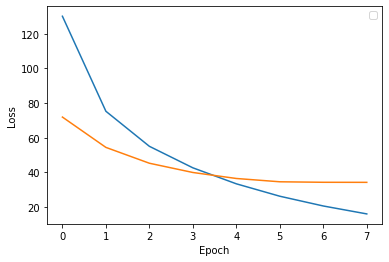

In [116]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.plot(training_losses, label = 'Training')
plt.plot(validation_losses, label = 'Validation')
plt.show()

In [117]:
model.load_state_dict(torch.load('encoder_decoder_without_attention.pt'))

test_loss = evaluate(model, test_data_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |')

| Test Loss: 3.582 | Test PPL:  35.948 |


In [118]:
def translate(text):
  model.eval()
  with torch.no_grad():
    tokens = english_tokenizer(text)
    tokens = [ENGLISH.init_token] + tokens + [ENGLISH.eos_token]
    src_indexes = [ENGLISH.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_tensor = src_tensor.reshape(-1,1)

    output = model(src_tensor, src_tensor)
    output_dim = output.shape[-1]
    output = output.view(-1, output_dim)
    indices = torch.argmax(output,dim=1).tolist()
    return [HINDI.vocab.itos[x] for x in indices]

print(translate("man speaks in native language"))

['साढ़े', '[', 'अपनी', 'में', 'में', 'में', 'रहा']


In [119]:
for i, torch_sentence_pair in enumerate(test_data):
  
    eng_sentence = vars(torch_sentence_pair)["english"]
    hin_sentence = vars(torch_sentence_pair)["hindi"]


    hindi_predicted = translate(" ".join(eng_sentence))
    hindi_predicted = " ".join(list(filter(lambda x: x != '<eos>' and x!= '<unk>', hindi_predicted))[1:])
    
    if i == 500:
      break
